# Amazon Product Reviews Sentiment Analysis 

In [ ]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
#https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/
#https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8

In [ ]:
#!pip install vaderSentiment

In [ ]:
#!pip install nltk

In [1]:
import pandas as pd
import io
import re
import requests
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from collections import Counter
from nltk import word_tokenize
from nltk import ne_chunk

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Manali\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Manali\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [7]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Manali\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## 1. Loading the data

In [8]:
amazon_books_data = pd.read_csv("data/updated_amazon_books.csv")

In [9]:
amazon_books_data.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,...,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,word_count
0,282,US,14213000,R34ZTQTHWRHT5R,1893183246,42346661,"Voyagers: The Sleeping Abductees Volume 1, 2nd...",Books,5.0,18.0,...,"This volume offers clear, accurate, directly t...",'Ashayana Deane',http://books.google.com/books/content?id=MxIFA...,http://books.google.com/books?id=MxIFAAAACAAJ&...,Granite Pub Llc,2001-06-01,http://books.google.com/books?id=MxIFAAAACAAJ&...,'Fiction',1.0,417.0
1,283,US,13161269,R1PFAFAO80F0D6,1893183246,42346661,"Voyagers: The Sleeping Abductees Volume 1, 2nd...",Books,5.0,2.0,...,"This volume offers clear, accurate, directly t...",'Ashayana Deane',http://books.google.com/books/content?id=MxIFA...,http://books.google.com/books?id=MxIFAAAACAAJ&...,Granite Pub Llc,2001-06-01,http://books.google.com/books?id=MxIFAAAACAAJ&...,'Fiction',1.0,37.0
2,284,US,12183412,R34C7UF8UIAARN,1893183246,42346661,"Voyagers: The Sleeping Abductees Volume 1, 2nd...",Books,5.0,3.0,...,"This volume offers clear, accurate, directly t...",'Ashayana Deane',http://books.google.com/books/content?id=MxIFA...,http://books.google.com/books?id=MxIFAAAACAAJ&...,Granite Pub Llc,2001-06-01,http://books.google.com/books?id=MxIFAAAACAAJ&...,'Fiction',1.0,509.0
3,285,US,23215759,R3LW6T95W2WA13,1893183246,42346661,"Voyagers: The Sleeping Abductees Volume 1, 2nd...",Books,5.0,9.0,...,"This volume offers clear, accurate, directly t...",'Ashayana Deane',http://books.google.com/books/content?id=MxIFA...,http://books.google.com/books?id=MxIFAAAACAAJ&...,Granite Pub Llc,2001-06-01,http://books.google.com/books?id=MxIFAAAACAAJ&...,'Fiction',1.0,96.0
4,286,US,15841011,R2LZ6MX96V6J5M,1893183246,42346661,"Voyagers: The Sleeping Abductees Volume 1, 2nd...",Books,1.0,11.0,...,"This volume offers clear, accurate, directly t...",'Ashayana Deane',http://books.google.com/books/content?id=MxIFA...,http://books.google.com/books?id=MxIFAAAACAAJ&...,Granite Pub Llc,2001-06-01,http://books.google.com/books?id=MxIFAAAACAAJ&...,'Fiction',1.0,100.0


In [10]:
amazon_books_data.shape

(217976, 26)

## 2. Preprocessing

In [11]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)      # replace won't with "will not"
    phrase = re.sub(r"can\'t", "can not", phrase)      # replace can or cant with 'can not'
    phrase = re.sub(r"n\'t", " not", phrase)           # replece n with 'not'
    phrase = re.sub(r"\'re", " are", phrase)           # replace re with 'are'
    phrase = re.sub(r"\'s", " is", phrase)             # replace s with 'is'
    phrase = re.sub(r"\'d", " would", phrase)          # replace 'd' with 'would'
    phrase = re.sub(r"\'ll", " will", phrase)          # replace 'll with 'will'
    phrase = re.sub(r"\'t", " not", phrase)            # replace 't' with 'not'
    phrase = re.sub(r"\'ve", " have", phrase)          # replace ve with 'have'
    phrase = re.sub(r"\'m", " am", phrase)             # replace 'm with 'am'
    return phrase

In [12]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
#print(stopwords)
len(stopwords)

179

In [13]:
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text_data):
    preprocessed_text = []             
    
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)                  #calling funcion for each sentence
        #print("1st sent" , sent)
        sent = sent.replace('\\r', ' ')                # replace line terminator with space
        sent = sent.replace('\\n', ' ')                # replace new line charactor with space
        sent = sent.replace('\\"', ' ')         
        sent = re.sub('[^A-Za-z]+', ' ', sent)        # remove anything that is not letter
        sent = ''.join(p_stemmer.stem(token) for token in sent )
        sent = ''.join(lemmatizer.lemmatize(token) for token in sent )
        sent  = ' '.join(e for e in sent.split() if len( Counter(e)) > 2 )
        #sent = lstr(emmatize_text(sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords ) # checking for stop words
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [14]:
cleaned_headlines = preprocess_text(amazon_books_data.review_headline)

100%|████████████████████████████████████████████████████████████████████████| 217976/217976 [00:26<00:00, 8109.84it/s]


In [15]:
cleaned_body = preprocess_text(amazon_books_data.review_body)

100%|█████████████████████████████████████████████████████████████████████████| 217976/217976 [14:00<00:00, 259.45it/s]


In [16]:
amazon_books_data["cleaned_review_headlines"] = cleaned_headlines
amazon_books_data['cleaned_review_body'] = cleaned_body

In [17]:
amazon_books_data["cleaned_review_headlines"][:10]

0                                         enlightening
1                                          interesting
2    great book contains information help save huma...
3                         excellent source information
4       unreadable filled wtth incomprehensible detail
5                                     interesting read
6                                             voyagers
7                                              exelent
8                                         best one yet
9                  spiritual technology highest degree
Name: cleaned_review_headlines, dtype: object

In [18]:
amazon_books_data['cleaned_review_body'][:10]

0    determining subject matter books ordered wanti...
1    whole set lost fire loved reading set seemed l...
2    information book empowering yes cover informat...
3    fellow contactee found valuable clearest conci...
4    found book unreadable could read couple pages ...
5    full information went right head one things ne...
6    complicated read fascinating expected need awa...
7    book amassing purchased two voyagers books ang...
8    read many many books spirituality followed lot...
9    amazing book describes possible scenarios eart...
Name: cleaned_review_body, dtype: object

## 3. Wordcloud of Review headline and Review body

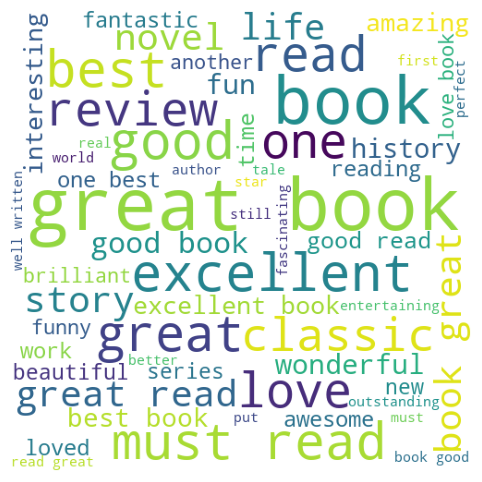

In [19]:
word_cloud = WordCloud(width=500,height=500,min_font_size=15,background_color='white')
colud_headline = word_cloud.generate(amazon_books_data[amazon_books_data['star_rating']> 3]['cleaned_review_headlines'].str.cat(sep=" "))

plt.figure(figsize=(10,6))
plt.axis('off')
plt.imshow(colud_headline)

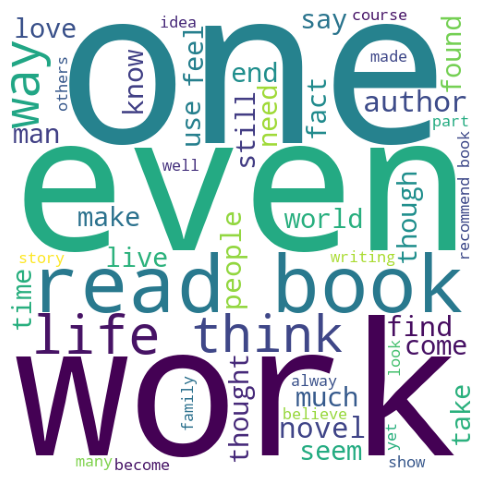

In [20]:
word_cloud = WordCloud(width=500,height=500,min_font_size=15,background_color='white')
cloud_body = word_cloud.generate(amazon_books_data[amazon_books_data['star_rating']> 3]['cleaned_review_body'].str.cat(sep=" "))

plt.figure(figsize=(10,6))
plt.axis('off')
plt.imshow(cloud_body)

## 4. Named Entity Recognition

In [21]:
def pos_ner_tagging(text_list):
    tagged_sentences = []
    ner_sentences = []
    for sentence in text_list:
        tokens = nltk.word_tokenize(sentence)
        tagged = nltk.pos_tag(tokens)
        tagged_sentences.append(tagged)
        
        named_entities = nltk.ne_chunk(tagged)
        ner_sentences.append(named_entities)
    return tagged_sentences, ner_sentences

In [22]:
#https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/
tagged_headlines, ner_headlines = pos_ner_tagging(cleaned_headlines)


In [23]:
tagged_body, ner_body = pos_ner_tagging(cleaned_body)

In [43]:
tagged_headlines[5] 

[('interesting', 'VBG'), ('read', 'NN')]

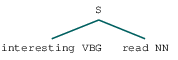

In [44]:
ner_headlines[5]

In [41]:
tagged_body[5]

[('full', 'JJ'),
 ('information', 'NN'),
 ('went', 'VBD'),
 ('right', 'JJ'),
 ('head', 'NN'),
 ('one', 'CD'),
 ('things', 'NNS'),
 ('need', 'VBP'),
 ('full', 'JJ'),
 ('attention', 'NN'),
 ('grasp', 'NN'),
 ('sometimes', 'RB')]

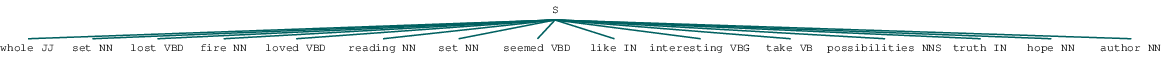

In [42]:
ner_body[1]

## 3. vaderSentiment

In [45]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
vader = SentimentIntensityAnalyzer()

#### Calculating Polarity score of reviews

In [52]:
amazon_books_data['headline_score'] = amazon_books_data['cleaned_review_headlines'].apply(lambda review: vader.polarity_scores(review))

In [55]:
amazon_books_data['body_score'] = amazon_books_data['cleaned_review_body'].apply(lambda review: vader.polarity_scores(review))

In [53]:
amazon_books_data['headline_score'][0]

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5106}

In [56]:
amazon_books_data['body_score'][0]

{'neg': 0.075, 'neu': 0.682, 'pos': 0.243, 'compound': 0.9867}

### 3.1. Converting Compunds values into Sentiments

In [59]:
headline_compound = amazon_books_data['headline_score'].apply(lambda score_dict: score_dict['compound'])

In [60]:
body_compound = amazon_books_data['body_score'].apply(lambda score_dict: score_dict['compound'])

In [61]:
#Converting Compunds values into Sentiments
def converting_compound_to_sentiments(compound_list) :
    sentiment_list = []
    
    for compund in compound_list:
        if compund >= 0.05 :
            sentiment_list.append("Positive")
        elif compund <= -0.05 :
            sentiment_list.append("Negative")
        else:
            sentiment_list.append("Neutral")
    
    return sentiment_list

In [62]:
sentiments_headline = converting_compound_to_sentiments(headline_compound)

In [63]:
sentiments_body = converting_compound_to_sentiments(body_compound)

## 5. Adding columns with Sentiments values

In [64]:
amazon_books_data['headline_compound'] = headline_compound

In [65]:
amazon_books_data['body_compound'] = body_compound

In [66]:
amazon_books_data['headline_sentiments'] = sentiments_headline

In [67]:
amazon_books_data['body_sentiments'] = sentiments_body

## 4. Lookup for the updated Data

In [69]:
updated_amazon_reviws_data =  amazon_books_data[[ 'categories','product_title','authors' , 'star_rating', 'review_headline', 'review_body','ratingsCount', 'word_count',
       'cleaned_review_headlines', 'cleaned_review_body', 'headline_score', 'body_score','headline_compound','body_compound', 'headline_sentiments', 'body_sentiments' ]]

In [70]:
updated_amazon_reviws_data.head()

,categories,product_title,authors,star_rating,review_headline,review_body,ratingsCount,word_count,cleaned_review_headlines,cleaned_review_body,headline_score,body_score,headline_compound,body_compound,headline_sentiments,body_sentiments
0,'Fiction',"Voyagers: The Sleeping Abductees Volume 1, 2nd...",'Ashayana Deane',5.0,Enlightening,After determining the subject matter of these ...,1.0,417.0,enlightening,determining subject matter books ordered wanti...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.075, 'neu': 0.682, 'pos': 0.243, 'co...",0.5106,0.9867,Positive,Positive
1,'Fiction',"Voyagers: The Sleeping Abductees Volume 1, 2nd...",'Ashayana Deane',5.0,Interesting,I had this whole set and lost in a fire. Love...,1.0,37.0,interesting,whole set lost fire loved reading set seemed l...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.174, 'neu': 0.296, 'pos': 0.53, 'com...",0.4019,0.8625,Positive,Positive
2,'Fiction',"Voyagers: The Sleeping Abductees Volume 1, 2nd...",'Ashayana Deane',5.0,Great Book! Contains Information That Can Help...,The information in this book is very empowerin...,1.0,509.0,great book contains information help save huma...,information book empowering yes cover informat...,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...","{'neg': 0.181, 'neu': 0.532, 'pos': 0.287, 'co...",0.8750,0.9809,Positive,Positive
3,'Fiction',"Voyagers: The Sleeping Abductees Volume 1, 2nd...",'Ashayana Deane',5.0,Excellent Source Of Information!!!,As a fellow contactee I have found this to be ...,1.0,96.0,excellent source information,fellow contactee found valuable clearest conci...,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...","{'neg': 0.027, 'neu': 0.655, 'pos': 0.318, 'co...",0.5719,0.9334,Positive,Positive
4,'Fiction',"Voyagers: The Sleeping Abductees Volume 1, 2nd...",'Ashayana Deane',1.0,Unreadable and filled wtth incomprehensible de...,I found this book to be unreadable. I could re...,1.0,100.0,unreadable filled wtth incomprehensible detail,found book unreadable could read couple pages ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.091, 'neu': 0.544, 'pos': 0.366, 'co...",0.0000,0.9566,Neutral,Positive


In [71]:
updated_amazon_reviws_data.to_csv("data/updated_amazon_reviws_data_vadar.csv")

In [ ]:
updated_amazon_reviws_data = pd.read_csv("data/updated_amazon_reviws_data_vadar.csv")

## 5. Negative, Neutral and Positive Sentiments

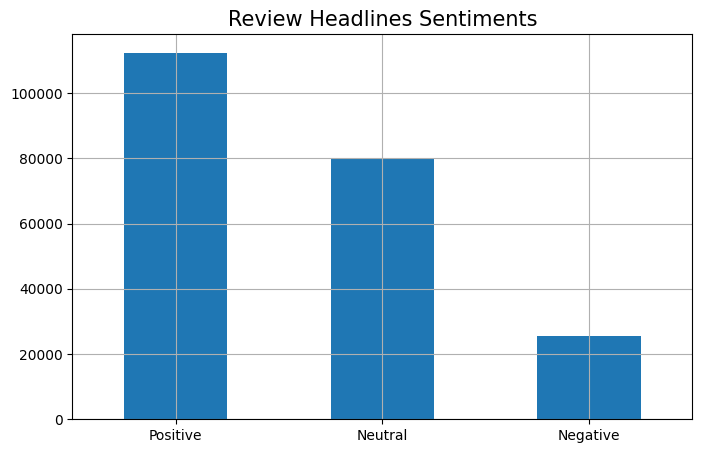

In [72]:
updated_amazon_reviws_data['headline_sentiments'].value_counts().plot(kind = 'bar', figsize = (8,5))
plt.xticks(rotation = 'horizontal')
plt.title('Review Headlines Sentiments',fontsize = 15)
plt.grid()
plt.show()

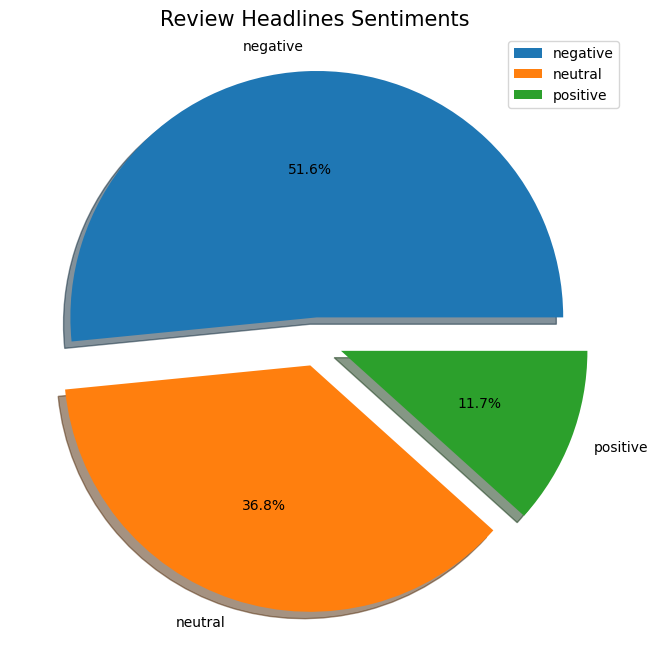

In [73]:
plt.rcParams['figure.figsize'] = (8,8)
sentiments = ['negative','neutral','positive']
plt.pie(updated_amazon_reviws_data['headline_sentiments'].value_counts(),explode =(0.1,0.1,0.1), labels = sentiments, autopct='%1.1f%%', shadow=True)
plt.title('Review Headlines Sentiments ', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

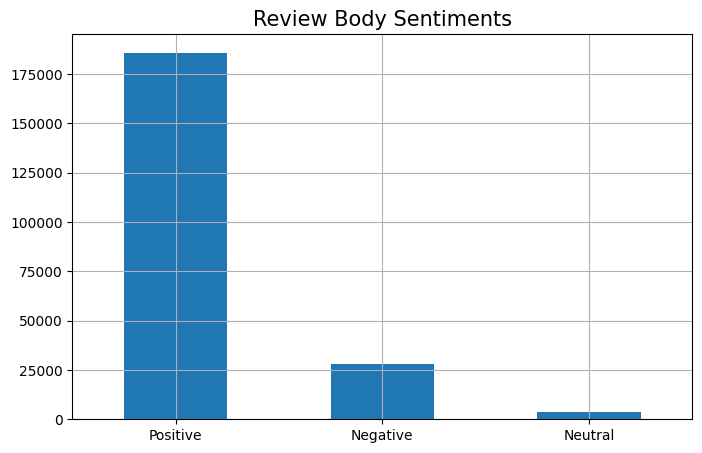

In [74]:
updated_amazon_reviws_data['body_sentiments'].value_counts().plot(kind = 'bar', figsize = (8,5))
plt.xticks(rotation = 'horizontal')
plt.title('Review Body Sentiments',fontsize = 15)
plt.grid()
plt.show()

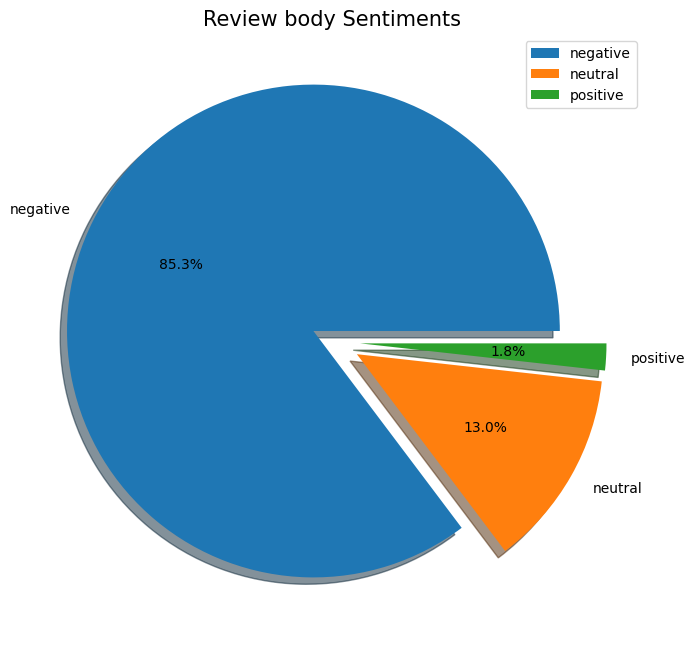

In [75]:
plt.rcParams['figure.figsize'] = (8,8)
sentiments = ['negative','neutral','positive']
plt.pie(updated_amazon_reviws_data['body_sentiments'].value_counts(),explode =(0.1,0.1,0.1), labels = sentiments, autopct='%1.1f%%', shadow=True)
plt.title('Review body Sentiments ', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

## 6. Compound Sentiment Distribution

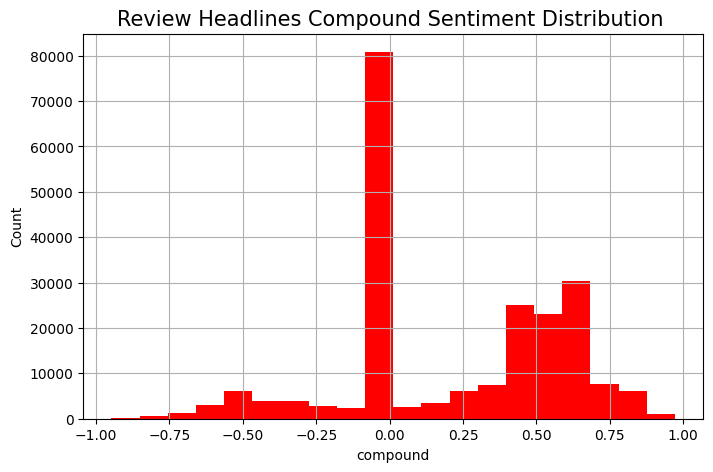

In [76]:
plt.figure(figsize = (8,5))
plt.hist(updated_amazon_reviws_data['headline_compound'],bins = 20,color = 'red')
plt.title('Review Headlines Compound Sentiment Distribution ',fontsize = 15)
plt.xlabel('compound')
plt.ylabel('Count')
plt.grid()
plt.show()

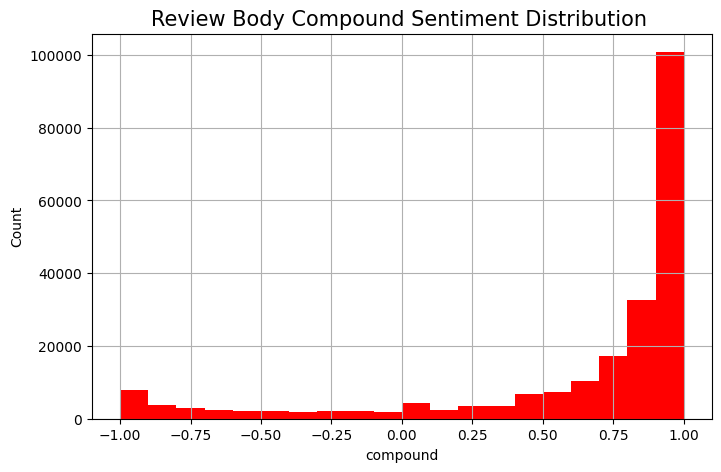

In [77]:
plt.figure(figsize = (8,5))
plt.hist(updated_amazon_reviws_data['body_compound'],bins = 20,color = 'red')
plt.title('Review Body Compound Sentiment Distribution ',fontsize = 15)
plt.xlabel('compound')
plt.ylabel('Count')
plt.grid()
plt.show()

## 7. Books with most Positive Headline Reviews

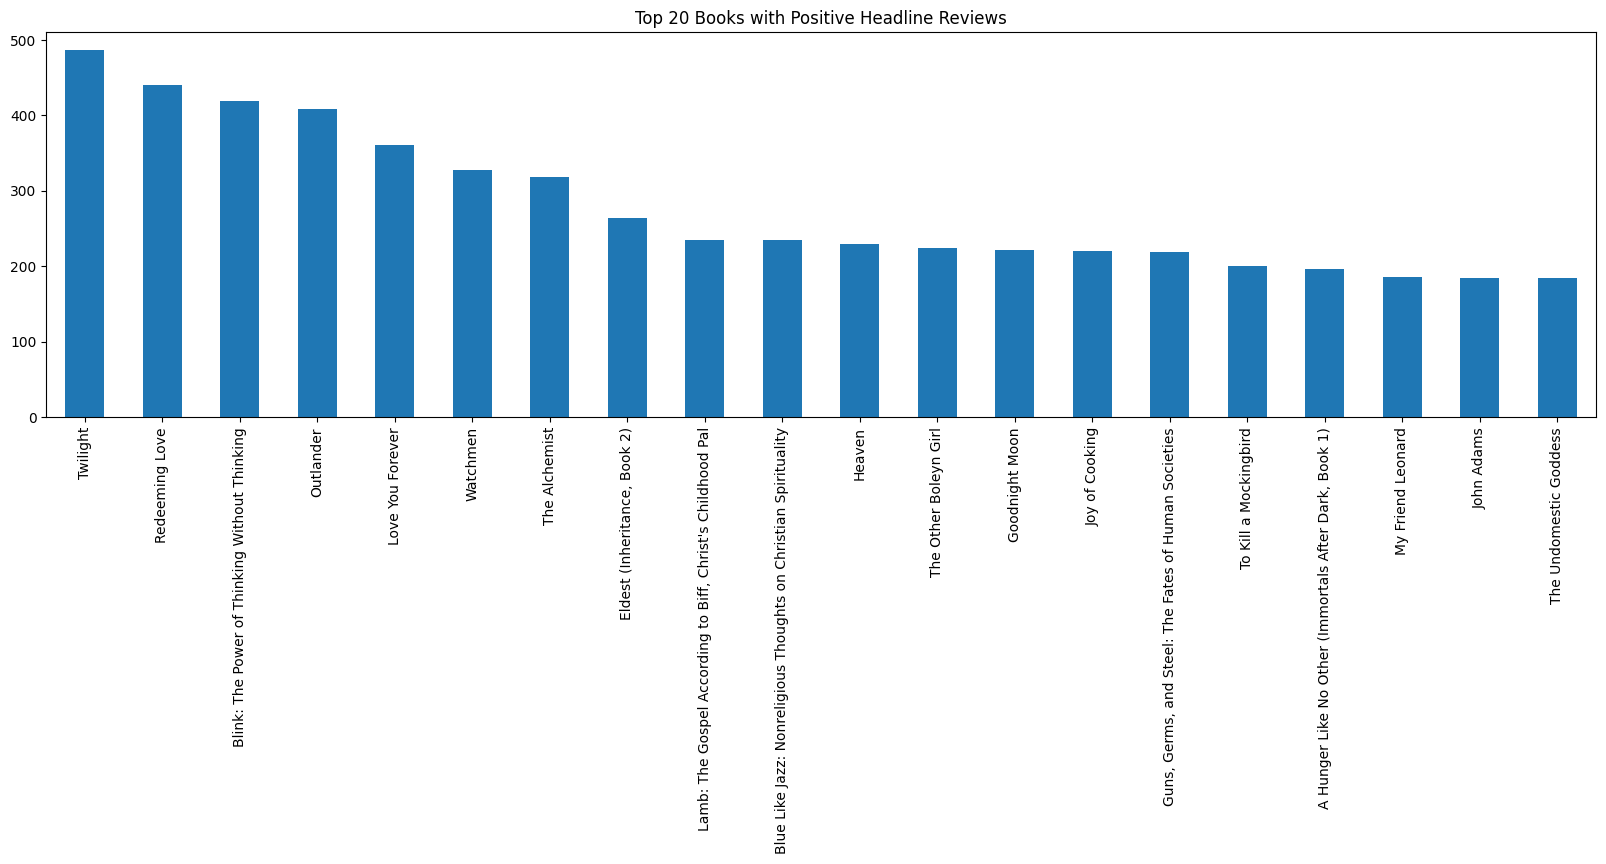

In [79]:
pos_book = updated_amazon_reviws_data[updated_amazon_reviws_data['headline_sentiments'] ==  'Positive' ]['product_title'].value_counts().head(20)
pos_book.plot(kind = 'bar', figsize = (20,5))
plt.title("Top 20 Books with Positive Headline Reviews")
plt.show()

## 8. Books with most Positive Body Reviews

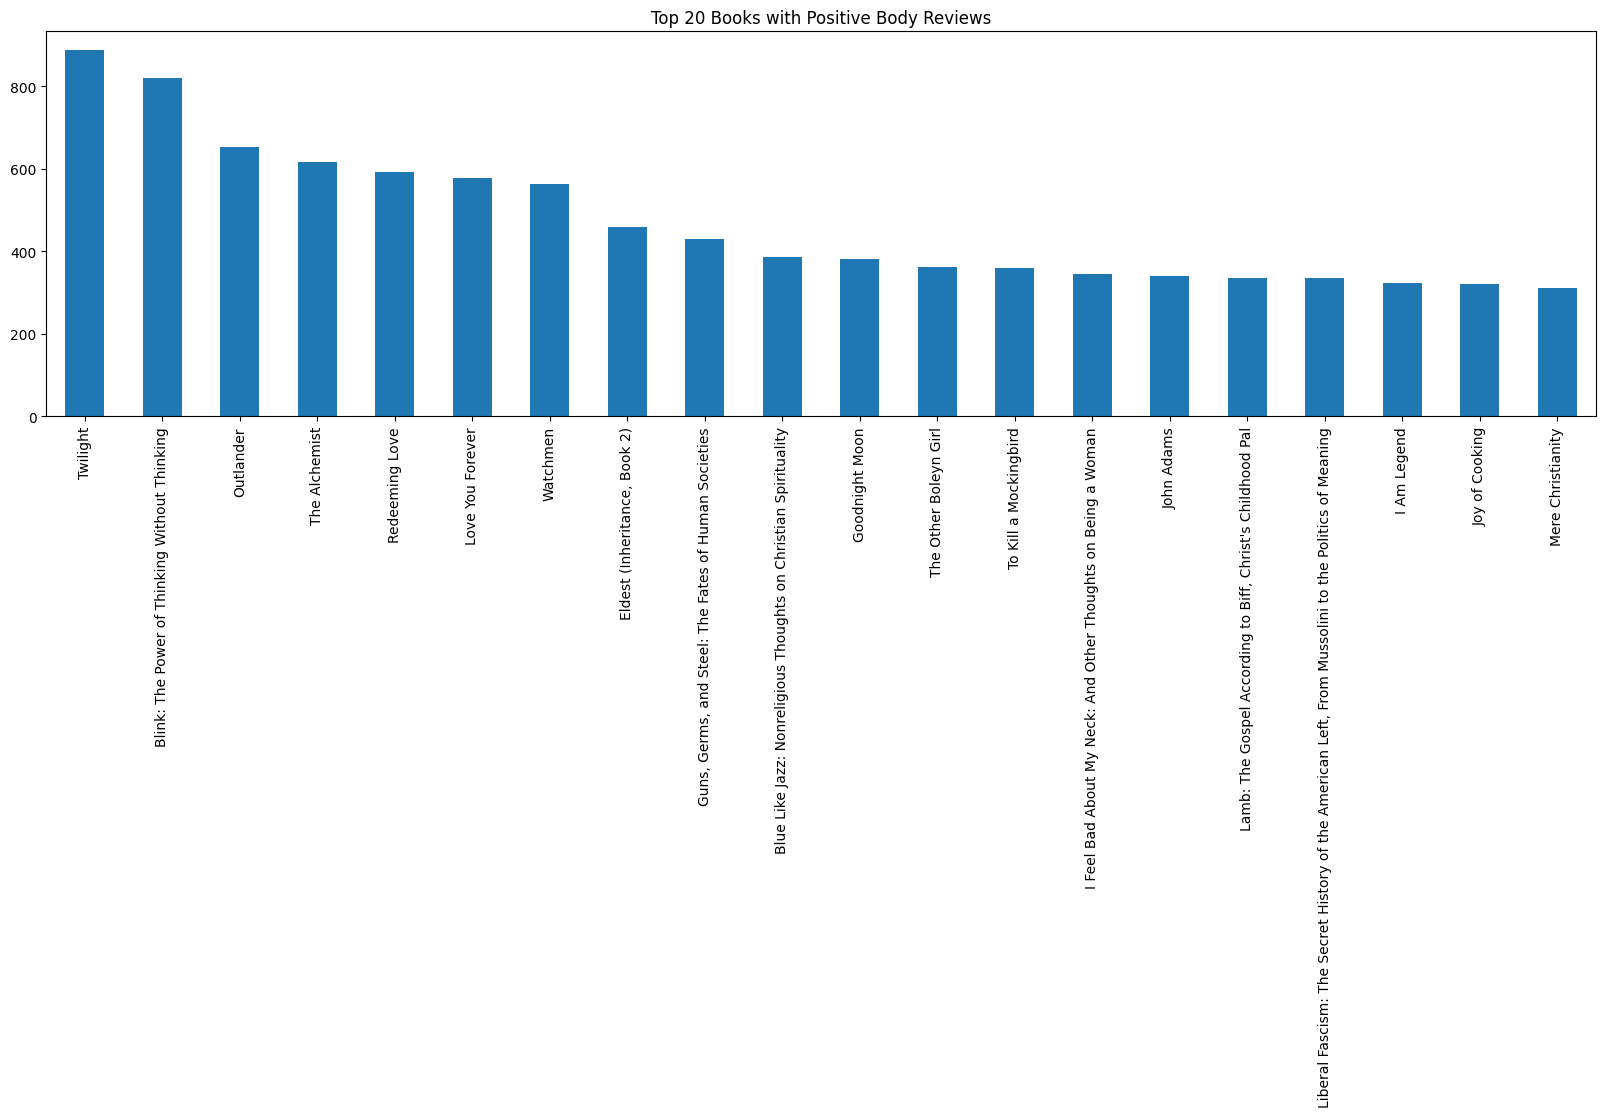

In [81]:
pos_body_book = updated_amazon_reviws_data[updated_amazon_reviws_data['body_sentiments'] ==  'Positive' ]['product_title'].value_counts().head(20)
pos_body_book.plot(kind = 'bar', figsize = (20,5))
plt.title("Top 20 Books with Positive Body Reviews")
plt.show()